Imports


In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np

import random
from datetime import date

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

! pip install nflows
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal, ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

     |████████████████████████████████| 45 kB 1.6 MB/s 
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53671 sha256=81a19aaaea3d534000c0fcae10f16763384f2fad3dd3e4be1374e1a1c5564ea5
  Stored in directory: /root/.cache/pip/wheels/c0/b6/52/0092eedabce8f7faa35b92522393fbdc1ec5ede99b0ec820d5
Successfully built nflows


# MNIST

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)

In [3]:
import gzip
import pickle

def load_data():
  f = gzip.open('mnist.pkl.gz', 'rb')

  # fix for encoding of pickle
  u = pickle._Unpickler(f)
  u.encoding = 'latin1'

  train_data, validation_data, test_data = u.load()
  f.close()

  return (train_data, validation_data, test_data)

In [4]:
def preprocess_data(data, rng, alpha=1.0e-6, logit=False, should_dequantize=True):
  """
  Processes the dataset
  """
  x = dequantize(data[0], rng) if should_dequantize else data[0]  # dequantize pixels
  x = logit_transform(x, alpha) if logit else x                   # logit
  labels = data[1]                                                # numeric labels
  encoded_labels = one_hot_encode(labels, 10)                     # 1-hot encoded labels
  return (x, labels, encoded_labels)

def dequantize(x, rng):
  """
  Adds noise to pixels to dequantize them
  """
  return x + rng.rand(*x.shape) / 256.0

def logit_transform(x, alpha=1.0e-6):
  """
  Transforms pixel values with logit to reduce the impact of boundary effects
  """
  a = alpha + (1 - 2*alpha) * x
  return np.log(a / (1.0 - a))

def one_hot_encode(labels, nr_labels):
  """
  Transforms numeric labels to 1-hot encoded labels
  """
  y = np.zeros([labels.size, nr_labels])
  y[range(labels.size), labels] = 1
  return y

In [5]:
def load_vectorized_data():
  train_data, validation_data, test_data = load_data()
  rng = np.random.RandomState(42)

  processed_train_data = preprocess_data(train_data, rng, logit=True)
  processed_validation_data = preprocess_data(validation_data, rng, logit=True)
  processed_test_data = preprocess_data(test_data, rng, logit=True)
  
  return (processed_train_data, processed_validation_data, processed_test_data)

In [13]:
train_data, validation_data, test_data = load_vectorized_data()

train_x = train_data[0]
train_labels = train_data[1]
train_y = train_data[2]

val_x = validation_data[0]
val_labels = validation_data[1]
val_y = validation_data[2]

test_x = test_data[0]
test_labels = test_data[1]
test_y = test_data[2]

In [6]:
def build_flow(num_dim, hidden_features=1024, layers=5, batch_norm=False):
  base_dist = StandardNormal(shape=[num_dim])
  transforms = []
  
  for _ in range(layers):
    transforms.append(ReversePermutation(features=num_dim))
    transforms.append(MaskedAffineAutoregressiveTransform(features=num_dim,
                                                          hidden_features=hidden_features,
                                                          use_batch_norm=batch_norm))
  transform = CompositeTransform(transforms)
  return Flow(transform, base_dist)

In [7]:
def build_cond_flow(num_dim, condition='digit', hidden_features=1024, layers=5, batch_norm=False):
  posible_conditioning = { 'digit': 10, 'color': 3 }
  context_features = posible_conditioning.get(condition, 1)
  base_dist = ConditionalDiagonalNormal(shape=[num_dim],
                                        context_encoder=nn.Linear(context_features, 2 * num_dim))
  transforms = []
  
  for _ in range(layers):
    transforms.append(ReversePermutation(features=num_dim))
    transforms.append(MaskedAffineAutoregressiveTransform(features=num_dim,
                                                          hidden_features=hidden_features,
                                                          use_batch_norm=batch_norm,
                                                          context_features=context_features))
  
  transform = CompositeTransform(transforms)
  return Flow(transform, base_dist)

In [8]:
def plot_loss_progress(progress_trn_loss, progress_val_loss, progress_epoch, best_epoch):
  fig, ax = plt.subplots(1, 1)
  ax.semilogx(progress_epoch, progress_trn_loss, 'b', label='training')
  ax.semilogx(progress_epoch, progress_val_loss, 'r', label='validation')
  ax.vlines(best_epoch, ax.get_ylim()[0], ax.get_ylim()[1], color='g', linestyles='dashed', label='best')
  ax.set_xlabel('epochs')
  ax.set_ylabel('loss')
  ax.legend()
  plt.show(block=False)

In [18]:
def train(flow, optimizer, train_loader, val_loader, patience=30, maxepochs=999, monitor_every_batch=False, show_epoch_loss_progress=False, show_flow=False, conditional=False, conditioning_criteria='digit'):
  best_val_loss = float('inf')
  best_epoch = None
  counter_step = 0
  progress_epoch = []
  progress_trn_loss = []
  progress_val_loss = []

  for epoch in range(1, maxepochs + 1):
    iter = 1

    t_loss = 0.0
    for x, y, l in train_loader:
      optimizer.zero_grad()
      train_loss = -flow.log_prob(inputs=x, context=y).mean() if conditional else -flow.log_prob(inputs=x).mean()
      train_loss.backward()
      optimizer.step()

      t_loss = train_loss.cpu().detach().numpy() if torch.cuda.is_available() else train_loss.detach().numpy()
      
      if monitor_every_batch:
        print('Epoch {}, Iteration {}, Train loss {:.5f}'.format(epoch, iter, t_loss))

      iter += 1

    v_loss = 0.0
    flow.eval()
    with torch.no_grad():
      for x, y, l in val_loader:
        val_loss = -flow.log_prob(inputs=x, context=y).mean() if conditional else -flow.log_prob(inputs=x).mean()
        v_loss = val_loss.cpu().detach().numpy() if torch.cuda.is_available() else val_loss.detach().numpy()
      
    progress_trn_loss.append(t_loss)
    progress_val_loss.append(v_loss)
    progress_epoch.append(epoch)

    print('Epoch: {}, Train loss: {:.5f}, Validation loss: {:.5f}'.format(epoch, t_loss, v_loss))

    if best_val_loss > v_loss:
      best_val_loss = v_loss
      today = date.today().strftime("%d-%m-%Y")
      filename = "MAF-MNIST-{}-{}-best.pth".format(conditioning_criteria if conditional else '', today)
      torch.save(flow, "/content/drive/MyDrive/Colab Notebooks/{}".format(filename))
      best_epoch = epoch
      counter_step = 0
    else:
      if counter_step == patience - 1:
        print('Stopped training after {} epochs'.format(epoch))
        break
      counter_step += 1
    
  if show_epoch_loss_progress:
    plot_loss_progress(progress_trn_loss, progress_val_loss, progress_epoch, best_epoch)

  return flow

In [10]:
def color_features(input, randomize=False):
  np.random.seed(42)
  colors = []
  colored_input = np.zeros((input.shape[0], 3, input.shape[1]))

  if randomize:
    rng = np.random.RandomState(42)
    colored_input = dequantize(colored_input, rng)

  for i in range(len(input))[:]:
    r = np.random.permutation([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    # print(r[0])
    colors.append(r[0])
    # print(np.argmax(r[0]))
    colored_input[i][np.argmax(r[0])][:] = input[i]
  
  colored_input = colored_input.reshape(colored_input.shape[0], 3*28*28)

  return (colored_input, np.array(colors))

In [11]:
def get_data_loader(data, batch_size, shuffle=True):
  x = torch.tensor(data[0], dtype=torch.float32)
  y = torch.tensor(data[1], dtype=torch.float32)
  z = torch.tensor(data[2], dtype=torch.float32)

  if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    z = z.cuda()

  dataset = TensorDataset(x, y, z)
  
  return DataLoader(dataset, batch_size, shuffle, num_workers=0)

In [14]:
batch_size = 100
weight_decay = 1.0e-6
lr = 1.0e-4
patience = 30
conditioning_criteria = 'color'
conditional = True

if conditioning_criteria == 'color':
  (train_x, train_y) = color_features(train_x)
  (val_x, val_y) = color_features(val_x)

num_dim = train_x.shape[1]

train_loader = get_data_loader((train_x, train_y, train_labels), batch_size)
val_loader = get_data_loader((val_x, val_y, val_labels), batch_size)

flow = build_cond_flow(num_dim, condition=conditioning_criteria) if conditional else build_flow(num_dim)

if torch.cuda.is_available():
  flow = flow.to(device)

optimizer = optim.Adam(flow.parameters(),
                       lr=lr,
                       weight_decay=0 if weight_decay is None else weight_decay)

In [19]:
model2 = train(flow,
              optimizer,
              train_loader, 
              val_loader, 
              patience=patience,
              show_epoch_loss_progress=True,
              conditional=True,
              conditioning_criteria=conditioning_criteria)

KeyboardInterrupt: ignored

Epoch: 1, Train loss: -510.69421, Validation loss: -659.76709
Epoch: 2, Train loss: -5719.18359, Validation loss: -5542.20312
Epoch: 3, Train loss: -7244.37598, Validation loss: -7200.87744
Epoch: 4, Train loss: -7924.37598, Validation loss: -7992.81592
Epoch: 5, Train loss: -8498.37012, Validation loss: -8471.60352
Epoch: 6, Train loss: -9158.98828, Validation loss: -9151.60352
Epoch: 7, Train loss: 5367.64062, Validation loss: 5078.18311
Epoch: 8, Train loss: 556.32410, Validation loss: 586.21515
Epoch: 9, Train loss: -1455.16467, Validation loss: -1166.80798
Epoch: 10, Train loss: -3432.85815, Validation loss: -3074.36646
Epoch: 11, Train loss: -4592.09668, Validation loss: -4449.52979
Epoch: 12, Train loss: -5477.95557, Validation loss: -5590.49512
Epoch: 13, Train loss: -5741.99756, Validation loss: -6071.13916
Epoch: 14, Train loss: -7071.41797, Validation loss: -6788.11230
Epoch: 15, Train loss: -7413.80371, Validation loss: -7319.66992
Epoch: 16, Train loss: -7588.39990, Valida

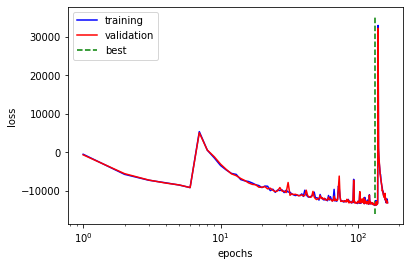

In [ ]:
model = train(flow,
              optimizer,
              train_loader, 
              val_loader, 
              patience=patience,
              show_epoch_loss_progress=True,
              conditional=True,
              conditioning_criteria=conditioning_criteria)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model, "/content/drive/MyDrive/Colab Notebooks/MAF-MNIST-2-11-2021-best.pth")

In [15]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/MAF-MNIST-color-23-11-2021-best.pth', map_location=device)

In [13]:
def inv_logit(x):
  alpha = 1.0e-6
  return (1.0 / (1.0 + np.exp(-x)) - alpha) / (1 - 2*alpha) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


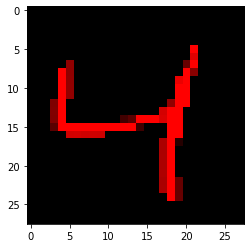

In [45]:
plt.imshow(np.transpose(tt_train_x[2].cpu().detach().numpy().reshape(3,28,28), (1,2,0)))
plt.show()

In [39]:
inv_logit(train_x[6]).max()

0.9999400565530893

In [ ]:
inv_logit(tt_train_x[0].cpu()).max()

tensor(0.9986)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


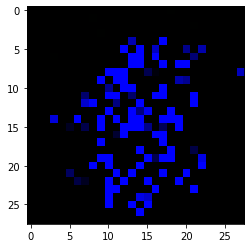

In [46]:
a = torch.tensor([0, 0, 1], dtype=torch.float32).cuda()


with torch.no_grad():
  z = model.sample(1, context=a.reshape(-1, 3))
  z_cpu = z[0].cpu()
  plt.imshow(np.transpose(z_cpu.detach().numpy().reshape(3,28,28), (1,2,0)))
  plt.show()

In [ ]:
tt_train_y[0]

tensor([1., 0., 0.], device='cuda:0')

In [ ]:
tt_train_y[0].shape

torch.Size([3])

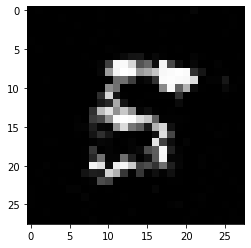

In [ ]:
plt.imshow(inv_logit(z_cpu).detach().numpy().reshape(28,28), cmap='gray')
plt.show()

In [ ]:
print(np.argmax(tt_train_y[0]))

tensor(5)


Test data

In [ ]:
tt_test_x = torch.tensor(test_x, dtype=torch.float32)
tt_test_y = torch.tensor(test_y, dtype=torch.float32)
tt_test_labels = torch.tensor(test_labels, dtype=torch.float32)

if torch.cuda.is_available():
  tt_test_x = tt_test_x.to(device)
  tt_test_y = tt_test_y.to(device)
  tt_test_labels = tt_test_labels.to(device)



# Conditioned Moons


In [ ]:
import sklearn.datasets as datasets

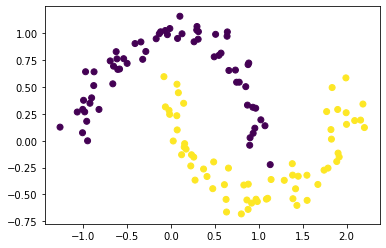

In [ ]:
x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

In [ ]:
num_layers = 5
base_dist = ConditionalDiagonalNormal(shape=[2], 
                                      context_encoder=nn.Linear(1, 4))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4, 
                                                          context_features=1))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [ ]:
num_iter = 5000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    print("x:{}".format(x.shape))
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    print("y:{}".format(y.shape))
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.5, 2.5)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid0 = flow.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
            zgrid1 = flow.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

In [ ]:
x, y = datasets.make_moons(128, noise=.1)
train_y[0].reshape(-1, 1).shape
print(train_x.shape)
print(train_y.shape)

(50000, 784)
(50000, 10)
